In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:41479")
client

<Client: 'tcp://127.0.0.1:41479' processes=2 threads=2, memory=5.86 GiB>

In [2]:
import xarray as xr
import numpy as np
import xrft
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
def synthetic_field(N, dL, amp, s):
    """
    Generate a synthetic series of size N by N
    with a spectral slope of s.
    """

    k = np.fft.fftshift(np.fft.fftfreq(N, dL))
    l = np.fft.fftshift(np.fft.fftfreq(N, dL))
    kk, ll = np.meshgrid(k, l)
    K = np.sqrt(kk**2 + ll**2)

    ########
    # amplitude
    ########
    r_kl = np.ma.masked_invalid(
        np.sqrt(amp * 0.5 * (np.pi) ** (-1) * K ** (s - 1.0))
    ).filled(0.0)
    ########
    # phase
    ########
    phi = np.zeros((N, N))

    N_2 = int(N / 2)
    phi_upper_right = 2.0 * np.pi * np.random.random((N_2 - 1, N_2 - 1)) - np.pi
    phi[N_2 + 1 :, N_2 + 1 :] = phi_upper_right.copy()
    phi[1:N_2, 1:N_2] = -phi_upper_right[::-1, ::-1].copy()

    phi_upper_left = 2.0 * np.pi * np.random.random((N_2 - 1, N_2 - 1)) - np.pi
    phi[N_2 + 1 :, 1:N_2] = phi_upper_left.copy()
    phi[1:N_2, N_2 + 1 :] = -phi_upper_left[::-1, ::-1].copy()

    phi_upper_middle = 2.0 * np.pi * np.random.random(N_2) - np.pi
    phi[N_2:, N_2] = phi_upper_middle.copy()
    phi[1:N_2, N_2] = -phi_upper_middle[1:][::-1].copy()

    phi_right_middle = 2.0 * np.pi * np.random.random(N_2 - 1) - np.pi
    phi[N_2, N_2 + 1 :] = phi_right_middle.copy()
    phi[N_2, 1:N_2] = -phi_right_middle[::-1].copy()

    phi_edge_upperleft = 2.0 * np.pi * np.random.random(N_2) - np.pi
    phi[N_2:, 0] = phi_edge_upperleft.copy()
    phi[1:N_2, 0] = -phi_edge_upperleft[1:][::-1].copy()

    phi_bot_right = 2.0 * np.pi * np.random.random(N_2) - np.pi
    phi[0, N_2:] = phi_bot_right.copy()
    phi[0, 1:N_2] = -phi_bot_right[1:][::-1].copy()

    phi_corner_leftbot = 2.0 * np.pi * np.random.random() - np.pi

    for i in range(1, N_2):
        for j in range(1, N_2):
            assert phi[N_2 + j, N_2 + i] == -phi[N_2 - j, N_2 - i]

    for i in range(1, N_2):
        for j in range(1, N_2):
            assert phi[N_2 + j, N_2 - i] == -phi[N_2 - j, N_2 + i]

    for i in range(1, N_2):
        assert phi[N_2, N - i] == -phi[N_2, i]
        assert phi[N - i, N_2] == -phi[i, N_2]
        assert phi[N - i, 0] == -phi[i, 0]
        assert phi[0, i] == -phi[0, N - i]
    #########
    # complex fourier amplitudes
    #########
    F_theta = r_kl * np.exp(1j * phi)

    # check that symmetry of FT is satisfied
    theta = np.fft.ifft2(np.fft.ifftshift(F_theta))
    return np.real(theta)


def synthetic_field_xr(
    Nt, N, dL, amp, s, other_dim_sizes=None, dim_order=True, chunks=None
):
    
    theta = xr.DataArray(np.ones((Nt,N,N)),
                         dims=['time','y','x'],
                         coords={"time":range(Nt), "y": range(N), "x": range(N)}
                        )
    for tt in range(Nt):
        theta.isel(time=tt)[:] = synthetic_field(N, dL, amp, s)

    if other_dim_sizes:
        _da = xr.DataArray(
            np.ones(other_dim_sizes),
            dims=["d%d" % i for i in range(len(other_dim_sizes))],
        )
        if dim_order:
            theta = theta + _da
        else:
            theta = _da + theta

    if chunks:
        theta = theta.chunk(chunks)

    return theta


In [45]:
s = -3.
da = synthetic_field_xr(10, 256, 1., 1., s, chunks={'time':1})
da

/tmp/ipykernel_30689/1960383124.py:16: RuntimeWarning: divide by zero encountered in power
  np.sqrt(amp * 0.5 * (np.pi) ** (-1) * K ** (s - 1.0))


<xarray.DataArray (time: 10, y: 256, x: 256)>
dask.array<xarray-<this-array>, shape=(10, 256, 256), dtype=float64, chunksize=(1, 256, 256), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) int64 0 1 2 3 4 5 6 7 8 9
  * y        (y) int64 0 1 2 3 4 5 6 7 8 ... 247 248 249 250 251 252 253 254 255
  * x        (x) int64 0 1 2 3 4 5 6 7 8 ... 247 248 249 250 251 252 253 254 255

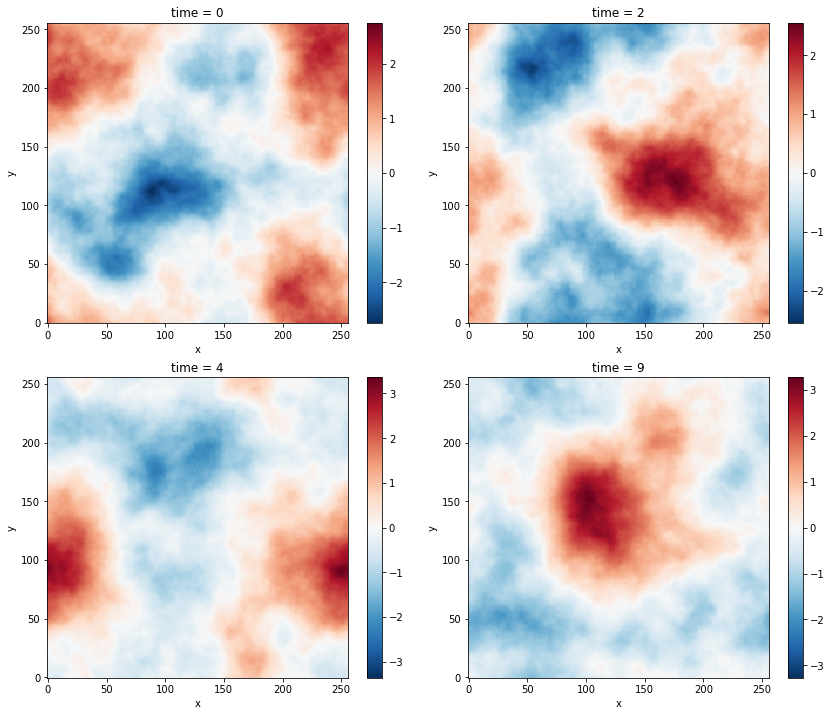

In [46]:
fig, axes = plt.subplots(figsize=(12,10), nrows=2, ncols=2)
fig.set_tight_layout(True)

da.isel(time=0).plot(ax=axes[0,0])
da.isel(time=2).plot(ax=axes[0,1])
da.isel(time=4).plot(ax=axes[1,0])
da.isel(time=-1).plot(ax=axes[1,1])

axes[0,0].set_aspect('equal')
axes[0,1].set_aspect('equal')
axes[1,0].set_aspect('equal')
axes[1,1].set_aspect('equal')

In [47]:
iso_da = xrft.isotropic_power_spectrum(da, dim=['y','x'], truncate=True)
iso_da

<xarray.DataArray (time: 10, freq_r: 45)>
dask.array<getitem, shape=(10, 45), dtype=float64, chunksize=(1, 45), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) int64 0 1 2 3 4 5 6 7 8 9
  * freq_r   (freq_r) float64 0.007322 0.01719 0.02797 ... 0.4695 0.4806 0.4917

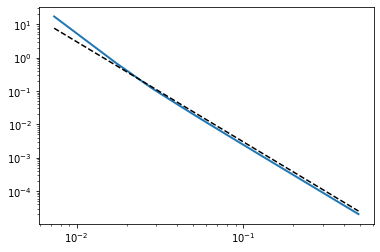

In [48]:
fig, ax = plt.subplots()
ax.plot(iso_da.freq_r, iso_da.mean('time'), lw=2)
ax.plot(iso_da.freq_r, iso_da.freq_r**s*3e-6, 'k--')
ax.set_xscale('log')
ax.set_yscale('log')

In [38]:
s = -5/3
da = synthetic_field_xr(10, 256, 1., 1., s, chunks={'time':1})
da

/tmp/ipykernel_30689/1960383124.py:16: RuntimeWarning: divide by zero encountered in power
  np.sqrt(amp * 0.5 * (np.pi) ** (-1) * K ** (s - 1.0))


<xarray.DataArray (time: 10, y: 256, x: 256)>
dask.array<xarray-<this-array>, shape=(10, 256, 256), dtype=float64, chunksize=(1, 256, 256), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) int64 0 1 2 3 4 5 6 7 8 9
  * y        (y) int64 0 1 2 3 4 5 6 7 8 ... 247 248 249 250 251 252 253 254 255
  * x        (x) int64 0 1 2 3 4 5 6 7 8 ... 247 248 249 250 251 252 253 254 255

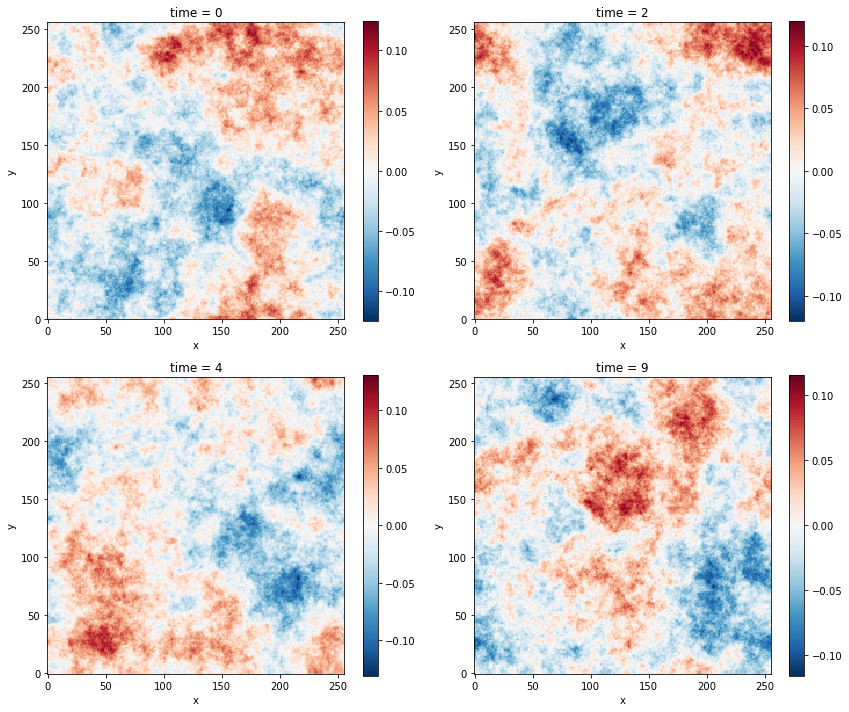

In [39]:
fig, axes = plt.subplots(figsize=(12,10), nrows=2, ncols=2)
fig.set_tight_layout(True)

da.isel(time=0).plot(ax=axes[0,0])
da.isel(time=2).plot(ax=axes[0,1])
da.isel(time=4).plot(ax=axes[1,0])
da.isel(time=-1).plot(ax=axes[1,1])

axes[0,0].set_aspect('equal')
axes[0,1].set_aspect('equal')
axes[1,0].set_aspect('equal')
axes[1,1].set_aspect('equal')

In [29]:
iso_da = xrft.isotropic_power_spectrum(da, dim=['y','x'], truncate=True)
iso_da

<xarray.DataArray (time: 10, freq_r: 45)>
dask.array<getitem, shape=(10, 45), dtype=float64, chunksize=(1, 45), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) int64 0 1 2 3 4 5 6 7 8 9
  * freq_r   (freq_r) float64 0.007322 0.01719 0.02797 ... 0.4695 0.4806 0.4917

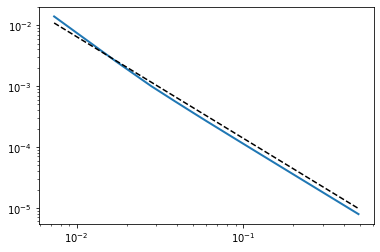

In [41]:
fig, ax = plt.subplots()
ax.plot(iso_da.freq_r, iso_da.mean('time'), lw=2)
ax.plot(iso_da.freq_r, iso_da.freq_r**s*3e-6, 'k--')
ax.set_xscale('log')
ax.set_yscale('log')